<a href="https://colab.research.google.com/github/georgianpartners/Transformers-Domain-Adaptation/blob/master/notebooks/GuideToTransformersDomainAdaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guide to Transformers Domain Adaptation
This guide illustrates an end-to-end workflow of domain adaptation, where we domain-adapt a transfomer model for biomedical NLP applications.

It showcases the two domain adaptation techniques we investigated in our research:
1. Data Selection
2. Vocabulary Augmentation

Following that, we demonstrate how such a domain-adapted Transformers model is compatible with 🤗 `transformers`'s training interface and how it outperforms an out-of-the-box (non-domain adapted) model.

These techniques are applied to BERT small but the codebase is written to be generalizable to other classes of Transformers supported by HuggingFace.

### Caveats
For this guide, we use a much smaller subset (<0.05%) of the in-domain corpora due to memory and time constraints. 

### Setup: Install dependencies
We begin by installing `adatation-metrics` using `pip`.

### Setup: Download demo files

## Constants
We first define some constants, including the appropriate model card and relevant paths to text corpora.

There are two types of corpora in the context of Domain Adaptation:

1. Fine-Tuning Corpus
> Given an NLP task (e.g. text classification, summarization, etc.), the text portion of this dataset is the fine-tuning corpus.

2. In-Domain Corpus
> This is an unsupervised text dataset that is used for domain pre-training. The text domain is the same as, if not broader than, the domain of fine-tuning corpus.

In [2]:
model_card = 'bert-base-uncased'

# Domain-pre-training corpora
dpt_corpus_train = 'data/pubmed_subset_train.txt'
dpt_corpus_train_data_selected = 'data/pubmed_subset_train_data_selected.txt'
dpt_corpus_val = 'data/pubmed_subset_val.txt'

# Fine-tuning corpora
# If there are multiple downstream NLP tasks/corpora, you can concatenate those files together
ft_corpus_train = 'data/BC2GM_train.txt'

### Load model and tokenizer
Next we load the model and its corresponding tokenizer.

In [3]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

model = AutoModelForMaskedLM.from_pretrained(model_card)
tokenizer = AutoTokenizer.from_pretrained(model_card, use_fast=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [1]:
from huggingface_hub import notebook_login
notebook_login()

## Data Selection
Not all data in the in-domain corpora may be helpful or relevant during domain pre-training. For irrelevant documents, at best, it does not degrade the domain-adapted model performance. At worst, the model regresses and loses valuable pre-trained information — catastrophic forgetting.

As such, we select documents from the in-domain corpus that are likely to be relevant for the downstream fine-tuning dataset(s), using a variety of similarity and diversity metrics designed by Ruder & Plank.

Reference:
- Sebastian Ruder and Barbara Plank. Learning to select data for transfer learning with Bayesian Optimization. In *Proceedings of the 2017 Conference on Empirical Methods in Natural Language Processing.* 2017.

In [4]:


from adatation_metrics import DataSelector


selector = DataSelector(
    keep=0.5,  # TODO Replace with `keep`
    tokenizer=tokenizer,
    similarity_metrics=['euclidean'],
    diversity_metrics=[
        "type_token_ratio",
        "entropy",
    ],
)

In [5]:
from pathlib import Path


from datasets import load_dataset

model_card = 'bert-base-uncased'
subdomains = {
    'fake_news':load_dataset('redasers/difraud', 'fake_news'),
    'phishing':load_dataset('redasers/difraud', 'phishing'),
    'job_scams':load_dataset('redasers/difraud', 'job_scams'),
    'political_statements':load_dataset('redasers/difraud', 'political_statements'),
    'product_reviews':load_dataset('redasers/difraud', 'product_reviews'),
    'sms':load_dataset('redasers/difraud', 'sms'),
    'twitter_rumours':load_dataset('redasers/difraud', 'twitter_rumours'),
              }

dpt_corpus_train = []
dpt_corpus_val = []
yy_corpus_train = []
yy_corpus_val = []

for domain_name in subdomains:
  dpt_corpus_train.extend(subdomains[domain_name]['train']['text'])
  dpt_corpus_val.extend(subdomains[domain_name]['validation']['text'])
  yy_corpus_train.extend(subdomains[domain_name]['train']['label'])
  yy_corpus_val.extend(subdomains[domain_name]['validation']['label'])




import pandas as pd





Found cached dataset difraud (/home/dboumber/.cache/huggingface/datasets/redasers___difraud/fake_news/0.0.0/d88092f45d147d22bb5411f0ae197a948dfef2c1b8d6f5253753bcb1afea6eb2)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset difraud (/home/dboumber/.cache/huggingface/datasets/redasers___difraud/phishing/0.0.0/d88092f45d147d22bb5411f0ae197a948dfef2c1b8d6f5253753bcb1afea6eb2)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset difraud (/home/dboumber/.cache/huggingface/datasets/redasers___difraud/job_scams/0.0.0/d88092f45d147d22bb5411f0ae197a948dfef2c1b8d6f5253753bcb1afea6eb2)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset difraud (/home/dboumber/.cache/huggingface/datasets/redasers___difraud/political_statements/0.0.0/d88092f45d147d22bb5411f0ae197a948dfef2c1b8d6f5253753bcb1afea6eb2)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset difraud (/home/dboumber/.cache/huggingface/datasets/redasers___difraud/product_reviews/0.0.0/d88092f45d147d22bb5411f0ae197a948dfef2c1b8d6f5253753bcb1afea6eb2)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset difraud (/home/dboumber/.cache/huggingface/datasets/redasers___difraud/sms/0.0.0/d88092f45d147d22bb5411f0ae197a948dfef2c1b8d6f5253753bcb1afea6eb2)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset difraud (/home/dboumber/.cache/huggingface/datasets/redasers___difraud/twitter_rumours/0.0.0/d88092f45d147d22bb5411f0ae197a948dfef2c1b8d6f5253753bcb1afea6eb2)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
target = pd.DataFrame({"text":subdomains["twitter_rumours"]['train']['text'], "label":subdomains["twitter_rumours"]['train']['label'] }).sample(frac=1.0)
sources = pd.DataFrame({"text":dpt_corpus_val,  "label":yy_corpus_val}).sample(frac=0.1)

len(sources.text)

958

In [7]:
sources.head()

,text,label
5046,"Today, about 40 percent of guns are purchased ...",1
6953,this is the best dvd for the kids. they really...,1
4750,Position type: Paid Internship in the San Fran...,0
3018,Credit Union is constantly working to ensure s...,1
8592,Ok... The theory test? when are �_ going to bo...,0


In [8]:


# Fit on fine-tuning corpus
selector.fit(target.text.to_list())



Token indices sequence length is longer than the specified maximum sequence length for this model (167104 > 512). Running this sequence through the model will result in indexing errors


DataSelector(diversity_metrics=['type_token_ratio', 'entropy'], keep=0.5,
             similarity_metrics=['euclidean'],
             tokenizer=BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))

In [9]:
source_data=sources.text.to_list()

In [10]:
source_data

['Today, about 40 percent of guns are purchased without a background check.',
 'this is the best dvd for the kids. they really loved it this movie kept their eyes glued to the screen it really made a big difference to them happy they watched it.',
 'Position type: Paid Internship in the San Francisco office Start date: March 2014; 6 months minimum, 12 months preferred Compensation: Hourly or stipend, based on experience Reports to: Project Manager / Lead Developers Company overview: Amplifier Strategies is a social impact agency. We work with strategic philanthropists and visionary implementers who are tackling tough social and environmental challenges and taking their solutions to scale. We are a multidisciplinary team of strategists, designers and technologists who together offer a full suite of capabilities for our target markets. At Amplifier, we believe in a testing-based, iterative approach to services and product development. We strive to build great user experiences that have a

Since we specified `keep=0.5` in the `DataSelector`, the selected corpus should be half the size of the in-domain corpus, containing the top 50% most relevant documents.

In [11]:
docs=selector.transform(source_data)

computing diversity: 100%|██████████| 2/2 [00:00<00:00, 19.79metric/s]


In [12]:
docs

['And one more from Variety (this article was the main feature in their latest edition) Amy Dacey, CEO of the Democratic National Committee, says, "You have to go to where people are getting their information, and where people are watching. Some times I think candidates go to places where they think they can get their message across in a fast way, but they also diversify. They are talking to print reporters. They are talking on cable news. They are talking on social media. And they are having some appearances on some of these shows. But the bottom line is to get more people engaged and realizing about the election and what is at stake, so I think you have to factor in all of those things." Presidential Race Takes Over Pop Culture as Hopefuls Embrace Celebrity Status [Senior Editor] Ted Johnson Senior Editor Bernie Sanders looked exhausted as he got off a flight from Las Vegas in October at Burbank Bob Hope Airport and walked through the concourse, to be met by a reporter with a questio

In [14]:
selector.get_last_scores()

,euclidean,type_token_ratio,entropy,composite
0,-1.434492,-0.996271,-0.709170,-3.139933
1,-0.794742,-0.229362,-0.505252,-1.529356
2,0.441157,0.569190,0.920596,1.930942
3,0.321863,0.616571,0.418849,1.357282
4,-0.402183,-0.611778,-0.493139,-1.507099
...,...,...,...,...
953,0.608632,0.910349,0.911279,2.430260
954,0.500893,-0.282419,-0.299451,-0.080976
955,-0.383812,-0.439886,-0.312582,-1.136281
956,-1.859825,1.012650,0.905738,0.058563


In [17]:
counter = {}
for domain_name in subdomains:
    counter[domain_name] = 0
    for doc in docs:
        if doc in subdomains[domain_name]['validation']['text']:
            counter[domain_name] += 1
            
counter

{'fake_news': 188,
 'phishing': 112,
 'job_scams': 124,
 'political_statements': 0,
 'product_reviews': 53,
 'sms': 1,
 'twitter_rumours': 1}

In [23]:
len(sources)/2

479.0

<AxesSubplot:>

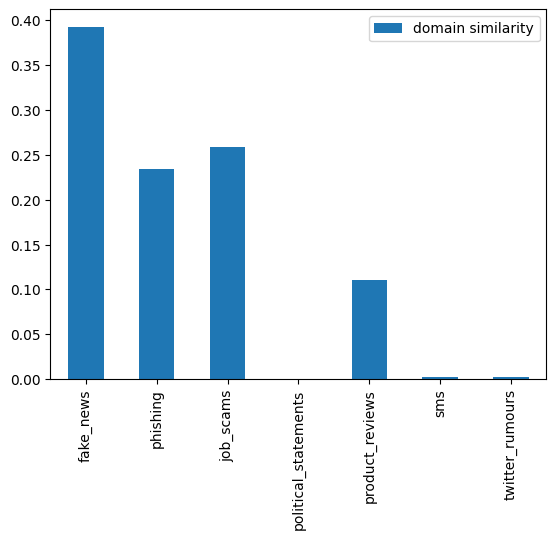

In [25]:
pd.DataFrame(data={"domain similarity":[v/479.0 for v in counter.values()]}, index=counter.keys()).plot(kind='bar')

## Vocabulary Augmentation
We can extend the existing vocabulary of the model to include domain-specific terminology. This allows for the representation such terminology to be explicit learnt during domain pre-training.

In [9]:
from adatation_metrics import VocabAugmentor

target_vocab_size = 31_000  # len(tokenizer) == 30_522

augmentor = VocabAugmentor(
    tokenizer=tokenizer, 
    cased=False, 
    target_vocab_size=target_vocab_size
)

# Obtain new domain-specific terminology based on the fine-tuning corpus
new_tokens = augmentor.get_new_tokens(ft_corpus_train)

In [10]:
print(new_tokens[:20])

['cdna', 'transcriptional', 'tyrosine', 'phosphorylation', 'kda', 'homology', 'enhancer', 'assays', 'exon', 'nucleotide', 'genomic', 'encodes', 'deletion', 'polymerase', 'nf', 'cloned', 'recombinant', 'putative', 'transcripts', 'homologous']


#### Update model and tokenizer with new vocab terminologies

In [11]:
tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

Embedding(31000, 768)

## Domain Pre-Training
Domain pre-training is the third step in domain adaptation — we continue training Transformer models with the same pre-training procedure on the in-domain corpus.

#### Create dataset

In [12]:
import itertools as it
from pathlib import Path
from typing import Sequence, Union, Generator

from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments

In [13]:
datasets = load_dataset(
    'text', 
    data_files={
        "train": dpt_corpus_train_data_selected, 
        "val": dpt_corpus_val
    }
)

tokenized_datasets = datasets.map(
    lambda examples: tokenizer(examples['text'], truncation=True, max_length=model.config.max_position_embeddings), 
    batched=True
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

Using custom data configuration default


Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-99d850ed1b15ea72/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab. Subsequent calls will reuse this data.


#### Instantiate TrainingArguments and Trainer

In [14]:
training_args = TrainingArguments(
    output_dir="./results/domain_pre_training",
    overwrite_output_dir=True,
    max_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",
    save_steps=50,
    save_total_limit=2,
    logging_steps=50,
    seed=42,
    # fp16=True,
    dataloader_num_workers=2,
    disable_tqdm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['val'],
    data_collator=data_collator,
    tokenizer=tokenizer,  # This tokenizer has new tokens
)

In [15]:
trainer.train()

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,2.802200,2.380539,36.291100,27.555000
100,2.494300,2.328287,39.298500,25.446000


TrainOutput(global_step=100, training_loss=2.648266372680664, metrics={'train_runtime': 170.8014, 'train_samples_per_second': 0.585, 'total_flos': 235678172444160, 'epoch': 0.16})

## Fine-Tuning for Specific Tasks
We can plug our domain-adapted model for any fine-tuning tasks supported by HuggingFace.

For this guide, we will compare the performance between an out-of-the-box (OOB) model performs against a domain-adapted model for Named Entity Recognitition on the BC2GM dataset, a popular biomedical benchmarking dataset.

Utility functions for NER preprocessing and evaluation are adapted from HuggingFace's [NER fine-tuning example notebook](https://github.com/huggingface/notebooks/blob/master/examples/token_classification.ipynb).

#### Preprocess raw dataset to form NER dataset

In [16]:
from typing import NamedTuple
from functools import partial
from typing_extensions import Literal

import numpy as np
from datasets import Dataset, load_dataset, load_metric


class Example(NamedTuple):
    token: str
    label: str
        
def load_ner_dataset(mode: Literal['train', 'val', 'test']):
    file = f"data/BC2GM_{mode}.tsv"
    examples = []
    with open(file) as f:
        token = []
        label = []
        for line in f:
            if line.strip() == "":
                examples.append(Example(token=token, label=label))
                token = []
                label = []
                continue
            t, l = line.strip().split("\t")
            token.append(t)
            label.append(l)
            
    res = list(zip(*[(ex.token, ex.label) for ex in examples]))
    d = {'token': res[0], 'labels': res[1]}
    return Dataset.from_dict(d)


def tokenize_and_align_labels(examples, tokenizer):
    tokenized_inputs = tokenizer(examples["token"], truncation=True, is_split_into_words=True)
    label_to_id = dict(map(reversed, enumerate(label_list)))

    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id[label[word_idx]])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label_to_id[label[word_idx]])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [17]:
%%capture
# Install `seqeval`
!pip install seqeval

In [18]:
label_list = ["O", "B", "I"]
metric = load_metric('seqeval')

train_dataset = load_ner_dataset('train')
val_dataset = load_ner_dataset('val')
test_dataset = load_ner_dataset('test')

#### Instantiate NER models
Here we instantiate three task-specific NER models for comparison:
1. `da_model`: A domain-adapted NER model we just trained in this guide
2. `da_full_corpus_model`: The same domain-adapted NER model except that it was trained on the full in-domain training corpus
3. `oob_model`: An out-of-the-box BERT NER model (not domain-adapted)

In [19]:
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification

best_checkpoint = './results/domain_pre_training/checkpoint-100'
da_model = AutoModelForTokenClassification.from_pretrained(best_checkpoint, num_labels=len(label_list))

da_full_corpus_model = AutoModelForTokenClassification.from_pretrained('./domain-adapted-bert', num_labels=len(label_list))
full_corpus_tokenizer = AutoTokenizer.from_pretrained('./domain-adapted-bert')

oob_tokenizer = AutoTokenizer.from_pretrained(model_card)
oob_model = AutoModelForTokenClassification.from_pretrained(model_card, num_labels=len(label_list))

Some weights of the model checkpoint at ./results/domain_pre_training/checkpoint-100 were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at ./results/do

#### Create datasets, TrainingArguments and Trainer for each model

In [20]:
from typing import Dict

from datasets import Dataset


def preprocess_datasets(tokenizer, **datasets) -> Dict[str, Dataset]:
    tokenize_ner = partial(tokenize_and_align_labels, tokenizer=tokenizer)
    return {k: ds.map(tokenize_ner, batched=True) for k, ds in datasets.items()}

######################
##### `da_model` #####
######################
da_datasets = preprocess_datasets(
    tokenizer, 
    train=train_dataset, 
    val=val_dataset, 
    test=test_dataset
)

training_args = TrainingArguments(
    output_dir="./results/domain_adapted_fine_tuning",
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    logging_steps=100,
    seed=42,
    fp16=True,
    dataloader_num_workers=2,
    disable_tqdm=False
)

da_trainer = Trainer(
    model=da_model,
    args=training_args,
    train_dataset=da_datasets['train'],
    eval_dataset=da_datasets['val'],
    data_collator=DataCollatorForTokenClassification(tokenizer),
    tokenizer=tokenizer,  # This tokenizer has new tokens
    compute_metrics=compute_metrics
)


##################################
##### `da_model_full_corpus` #####
##################################
da_full_corpus_datasets = preprocess_datasets(
    full_corpus_tokenizer, 
    train=train_dataset, 
    val=val_dataset, 
    test=test_dataset
)

training_args = TrainingArguments(
    output_dir="./results/domain_adapted_full_corpus_fine_tuning",
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    logging_steps=100,
    seed=42,
    fp16=True,
    dataloader_num_workers=2,
    disable_tqdm=False
)

da_full_corpus_trainer = Trainer(
    model=da_full_corpus_model,
    args=training_args,
    train_dataset=da_full_corpus_datasets['train'],
    eval_dataset=da_full_corpus_datasets['val'],
    data_collator=DataCollatorForTokenClassification(full_corpus_tokenizer),
    tokenizer=full_corpus_tokenizer,  # This tokenizer has new tokens
    compute_metrics=compute_metrics
)


#######################
##### `oob_model` #####
#######################
oob_datasets = preprocess_datasets(
    oob_tokenizer, 
    train=train_dataset, 
    val=val_dataset, 
    test=test_dataset
)

training_args = TrainingArguments(
    output_dir="./results/out_of_the_box_fine_tuning",
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    logging_steps=100,
    seed=42,
    fp16=True,
    dataloader_num_workers=2,
    disable_tqdm=False
)

oob_model_trainer = Trainer(
    model=oob_model,
    args=training_args,
    train_dataset=oob_datasets['train'],
    eval_dataset=oob_datasets['val'],
    data_collator=DataCollatorForTokenClassification(oob_tokenizer),
    tokenizer=oob_tokenizer,  # This is the original tokenizer (without domain-specific tokens)
    compute_metrics=compute_metrics
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


#### Train and evaluate `da_model`

In [21]:
da_trainer.train()
da_trainer.evaluate(da_datasets['test'])

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Runtime,Samples Per Second
100,0.256700,0.156244,0.618155,0.588832,0.603138,0.940869,8.431400,298.765000
200,0.147000,0.131594,0.659094,0.731315,0.693329,0.950794,8.463100,297.646000
300,0.133000,0.120914,0.662715,0.782776,0.717759,0.953289,8.720100,288.871000
400,0.116100,0.108870,0.715941,0.768073,0.741091,0.959788,8.575600,293.739000
500,0.076400,0.113966,0.731982,0.784001,0.757099,0.960742,8.563500,294.157000
600,0.074400,0.104922,0.734860,0.792228,0.762466,0.960941,8.607100,292.664000
700,0.073700,0.104427,0.767751,0.768423,0.768087,0.963669,8.656800,290.986000


{'epoch': 2.0,
 'eval_accuracy': 0.9627387229857107,
 'eval_f1': 0.7704200580800851,
 'eval_loss': 0.10370161384344101,
 'eval_precision': 0.7605588306549301,
 'eval_recall': 0.7805403613459307,
 'eval_runtime': 16.8883,
 'eval_samples_per_second': 298.313}

#### Train and evaluate `da_model_full_corpus`

In [22]:
da_full_corpus_trainer.train()
da_full_corpus_trainer.evaluate(da_full_corpus_datasets['test'])

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Runtime,Samples Per Second
100,0.231900,0.127792,0.671435,0.829809,0.742268,0.952202,8.246900,305.450000
200,0.108300,0.086280,0.817341,0.826690,0.821989,0.968876,8.064200,312.366000
300,0.089600,0.083020,0.807372,0.838995,0.822879,0.969839,8.014300,314.313000
400,0.080600,0.078229,0.801577,0.880763,0.839306,0.971885,8.141400,309.405000
500,0.050800,0.075855,0.843227,0.864125,0.853548,0.973716,8.172500,308.230000
600,0.052500,0.075362,0.845051,0.858232,0.851591,0.973550,8.057900,312.611000
700,0.047400,0.073649,0.851391,0.864818,0.858052,0.974442,8.029400,313.722000


{'epoch': 2.0,
 'eval_accuracy': 0.9735219505320274,
 'eval_f1': 0.8525919253132421,
 'eval_loss': 0.07559072971343994,
 'eval_precision': 0.8402066015656525,
 'eval_recall': 0.8653478513839249,
 'eval_runtime': 15.8564,
 'eval_samples_per_second': 317.726}

#### Train and evaluate `oob_model`

In [23]:
oob_model_trainer.train()
oob_model_trainer.evaluate(oob_datasets['test'])

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Runtime,Samples Per Second
100,0.229200,0.133785,0.678159,0.803118,0.735368,0.947964,8.654700,291.056000
200,0.135200,0.109798,0.745311,0.825984,0.783576,0.957941,8.660700,290.855000
300,0.117200,0.099117,0.782186,0.837120,0.808721,0.962326,8.699700,289.550000
400,0.101300,0.095984,0.827210,0.822420,0.824808,0.965538,8.725000,288.710000
500,0.069000,0.103978,0.788701,0.845731,0.816221,0.961440,8.690600,289.853000
600,0.064100,0.092247,0.827396,0.848404,0.837768,0.967232,8.671200,290.501000
700,0.064400,0.090411,0.829128,0.853749,0.841258,0.968306,8.821600,285.549000


{'epoch': 2.0,
 'eval_accuracy': 0.9656225918051692,
 'eval_f1': 0.8301952580195259,
 'eval_loss': 0.09698742628097534,
 'eval_precision': 0.8164734929017214,
 'eval_recall': 0.8443861266756507,
 'eval_runtime': 17.0649,
 'eval_samples_per_second': 295.226}

#### Results
We see that out of the three models, `da_full_corpus_model` (which was domain-adapted on the entire in-domain training corpus) outperforms the `oob_model` by over 2% on the test F1 score. In fact, this `da_full_corpus_model` model is one of many domain-adapted models we trained that outperforms SOTA on BC2GM.

Also, `da_model` underperforms `oob_model`. This is to be expected, as `da_model` underwent minimal domain pre-training in this guide.

## Conclusion
In this guide, you have seen how to use `DataSelector` and `VocabAugmentor` to domain-adapt a transformers model, by performing Data Selection and Vocabulary Augmentation respectively.

You have also seen that they are compatible with all of HuggingFace products: `transformers`, `tokenizers` and `datasets`.

Finally, it is shown that a model domain-adapted on the full in-domain corpus performs better than an out-of-the-box model.